In [28]:
import subprocess
import os
import ete3
import random
import numpy as np
from Bio import SeqIO
import pandas as pd
import multiprocessing
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns

#
# initial definitions
class cd:
    """
    Context manager for changing the current working directory
    """
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)

%cd /work/site_rate/sequence_simulation
%matplotlib inline

/work/site_rate/sequence_simulation


In [4]:
random.seed(12345)
np.random.seed(12345)
num_replicates      = 10
sequence_length     = 1000
num_rate_categories = 12

indelible_conf = '''\
/////////////////////////////////////////////////////////////////////////////////////
//                                                                                 //
//  INDELible V1.03 control file - site-rate project                               //
//                                                                                 //
//      Automaticaly generated, more information:                                  //
//          github.com/lthiberiol/fournierLab/tree/master/site_rates               //
//                                                                                 //
/////////////////////////////////////////////////////////////////////////////////////

[TYPE]  AMINOACID 1

[SETTINGS]
    [randomseed]   12345

[MODEL] model1  [submodel]  LG         //   LG
                [rates]     0 1.3 20    //   pinv=0, alpha=1.3, discrete gamma categories=20
                [statefreq]
                    0.083   0.078   0.035   0.059   // list of 20 numbers
                    0.006   0.031   0.082   0.080   // A R N D C
                    0.018   0.063   0.070   0.078   // Q E G H I
                    0.025   0.025   0.046   0.050   // L K M F P
                    0.054   0.008   0.025   0.084   // S T W Y V

[MODEL] modelHug [submodel]  LG                         //   LG
                 [rates]     0 0.8025 20                //   pinv=0, alpha=1.3, discrete gamma categories=20
                 [statefreq]
                    0.0790   0.0843   0.0346   0.0392   // list of 20 numbers
                    0.0055   0.0293   0.0535   0.0956   // A R N D C
                    0.0217   0.0704   0.0699   0.1008   // Q E G H I
                    0.0253   0.0280   0.0415   0.0519   // L K M F P
                    0.0516   0.0065   0.0217   0.0898   // S T W Y V

[TREE] T1  {t1}
[TREE] T2  {t2}
[TREE] T3  {t3}

[PARTITIONS] partition1 [T1 modelHug {length}]   // tree T1, model model1, root length 1000
[PARTITIONS] partition2 [T2 modelHug {length}]   // tree T2, model model1, root length 1000
[PARTITIONS] partition3 [T3 modelHug {length}]   // tree T3, model model1, root length 1000

[EVOLVE]    partition1  {num_replicates}   {t1_name}
            partition2  {num_replicates}   {t2_name}
            partition3  {num_replicates}   {t3_name}
'''

taxa_names = [f'taxa_{count:04}' for count in range(1,1001)]
base_tree  = ete3.Tree()
base_tree.populate(size=1000, names_library=taxa_names, random_branches=True)

In [5]:
trees = {}
for tree_name in 'abg hug_et_al'.split():
    tmp_tree       = ete3.Tree('../%s/species.tre' % tree_name)
    branch_lengths = [node.dist for node in tmp_tree.traverse() if not node.is_root()]
    
    trees[tree_name] = base_tree.copy()
    for node in trees[tree_name]:
        if node.is_root():
            continue
        node.dist = np.random.choice(branch_lengths)

out = open('control.txt', 'w')
out.write(indelible_conf.format(t1=base_tree.write(format=5, dist_formatter='%.20f'),  t1_name='random_br_length',
                                t2=trees['abg'].write(format=5, dist_formatter='%.20f'), t2_name='abg_br_length',
                                t3=trees['hug_et_al'].write(format=5, dist_formatter='%.20f'), t3_name='hug_br_length',
                                num_replicates=num_replicates, length=sequence_length))
out.close()

subprocess.call(['/work/site_rate/indelible/INDELibleV1.03/bin/indelible_1.03_OSX_intel'])

0

In [7]:
fasta = open('abg_br_length.fas').read().strip()
trees['abg'].write(outfile='abg/reference.tre', format=5, dist_formatter='%.20f')
for count, block in enumerate(fasta.split('\n     \n')):
    out = open('abg/%i.fas' % (count+1), 'w')
    out.write(block)
    out.close()

fasta = open('hug_br_length.fas').read().strip()
trees['hug_et_al'].write(outfile='hug/reference.tre', format=5, dist_formatter='%.20f')
for count, block in enumerate(fasta.split('\n     \n')):
    out = open('hug/%i.fas' % (count+1), 'w')
    out.write(block)
    out.close()

fasta = open('random_br_length.fas').read().strip()
base_tree.write(outfile='random/reference.tre', format=5, dist_formatter='%.20f')
for count, block in enumerate(fasta.split('\n     \n')):
    out = open('random/%i.fas' % (count+1), 'w')
    out.write(block)
    out.close()

In [8]:
#
# classify sites into rate-categories
def write_rates(argument):
    partition_name, replicate_number = argument
    subprocess.call(['iqtree', '-s', '%s/%i.fas' % (partition_name, replicate_number), '-m', 'LG+I+G12', '-redo',
                     '-safe', '-wsr', '-nt', '1', '-n', '0', '-pre', '%s/%i' % (partition_name, replicate_number),
                     '-te', '%s/reference.tre' % partition_name, '-quiet'])

In [9]:
num_threads = 10
pool = multiprocessing.Pool(processes=num_threads)
pool.map(write_rates, product('abg hug random'.split(), range(1, num_replicates+1)))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [10]:
#
# parse rates classification
#
for partition_name in 'abg hug random'.split():
    print(partition_name)

    with cd(partition_name):
        if not os.path.isdir('categories'):
            os.mkdir('categories')
        else:
            os.system('rm -r categories/*')

        for replicate in range(1, num_replicates+1):
            alignment = list(SeqIO.parse('%i.fas' % replicate, 'fasta'))

            rates = pd.read_table('%i.rate' % replicate, comment='#')
            for category in rates.Cat.unique():
                site_df        = rates[rates.Cat == category]
                category_aln   = {sequence.name:'' for sequence in alignment}
                for sequence in alignment:
                    category_aln[sequence.name] = ''.join([sequence[position] for position in site_df.index])

                out = open('categories/%i.%i.aln' % (replicate, category), 'w')
                for header, sequence in category_aln.items():
                    full_sequence = ''
                    while len(full_sequence) <= 1000:
                        full_sequence += sequence
                    out.write('>%s\n%s\n' % (header, full_sequence[:1000]))
                out.close()

abg
hug
random


In [12]:
def run_bootstrap(argument):
    replicate_number, category = argument
    subprocess.call(['iqtree', '-s', '%i.%i.aln' % (replicate_number, category), '-m', 'LG+G1', '-redo',
                     '-safe', '-nt', '1', '-pre', '%i.%i' % (replicate_number, category),
                     '-alrt', '1000', '-keep-ident', '-quiet', '-te', '../reference.tre'])

for partition_name in 'abg hug random'.split()[1:]:
    with cd('%s/categories' % partition_name):
        pool = multiprocessing.Pool(processes=18)
        pool.map(run_bootstrap, product(range(1, num_replicates+1), range(2, 13)))

Process ForkPoolWorker-53:
Process ForkPoolWorker-60:
Process ForkPoolWorker-47:
Process ForkPoolWorker-57:
Process ForkPoolWorker-62:
Process ForkPoolWorker-55:
Process ForkPoolWorker-49:
Process ForkPoolWorker-58:
Process ForkPoolWorker-50:
Process ForkPoolWorker-52:
Process ForkPoolWorker-51:
Process ForkPoolWorker-63:
Process ForkPoolWorker-54:
Process ForkPoolWorker-48:
Process ForkPoolWorker-64:
Process ForkPoolWorker-56:
Process ForkPoolWorker-61:
Process ForkPoolWorker-59:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent c

  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/queues.py", line 352, in get
    res = self._reader.recv_bytes()
  File "/Users/thiberio/anaconda2/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    tas

In [20]:
replicate, category

(1, 2)

In [24]:
%cd /work/site_rate/sequence_simulation/hug
category_support_df = pd.DataFrame(columns='replicate category topology_id support branch_length'.split())
for replicate in range(1, 11):
    print(replicate)
    for category in range(2, 13):
        print('\t', category)

        tmp_tree = ete3.Tree('categories/%i.%i.treefile' % (replicate, category))

        tmp_tree.set_outgroup(base_tree.children[0].get_leaf_names()[0])
        outgroup = tmp_tree.get_common_ancestor(base_tree.children[1].get_leaf_names())
        tmp_tree.set_outgroup(outgroup)

        tmp_supports       = []
        tmp_topology_ids   = []
        tmp_branch_lengths = []
        for node in tmp_tree.traverse():
            if not node.is_leaf() and not node.is_root():
                tmp_supports.append(node.support)
                tmp_topology_ids.append(node.get_topology_id())
                tmp_branch_lengths.append(node.dist)

        tmp_df = pd.DataFrame(
               list(zip([replicate]*len(tmp_supports),
                        [category]*len(tmp_supports),
                        tmp_topology_ids,
                        tmp_supports,
                        tmp_branch_lengths)),
                    columns='replicate category topology_id support branch_length'.split())
        category_support_df = category_support_df.append(tmp_df)

    for node in trees['hug_et_al'].traverse():
        if not node.is_leaf() and not node.is_root():
            tmp_topology_id = node.get_topology_id()
            category_support_df.loc[category_support_df.topology_id == tmp_topology_id, 'branch_length'] = node.dist

    category_support_df.to_csv('category_supports.tab', sep='\t')

/work/site_rate/sequence_simulation/hug
1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
2
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
3
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
4
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
5
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
6
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
7
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
8
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
9
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
10
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12


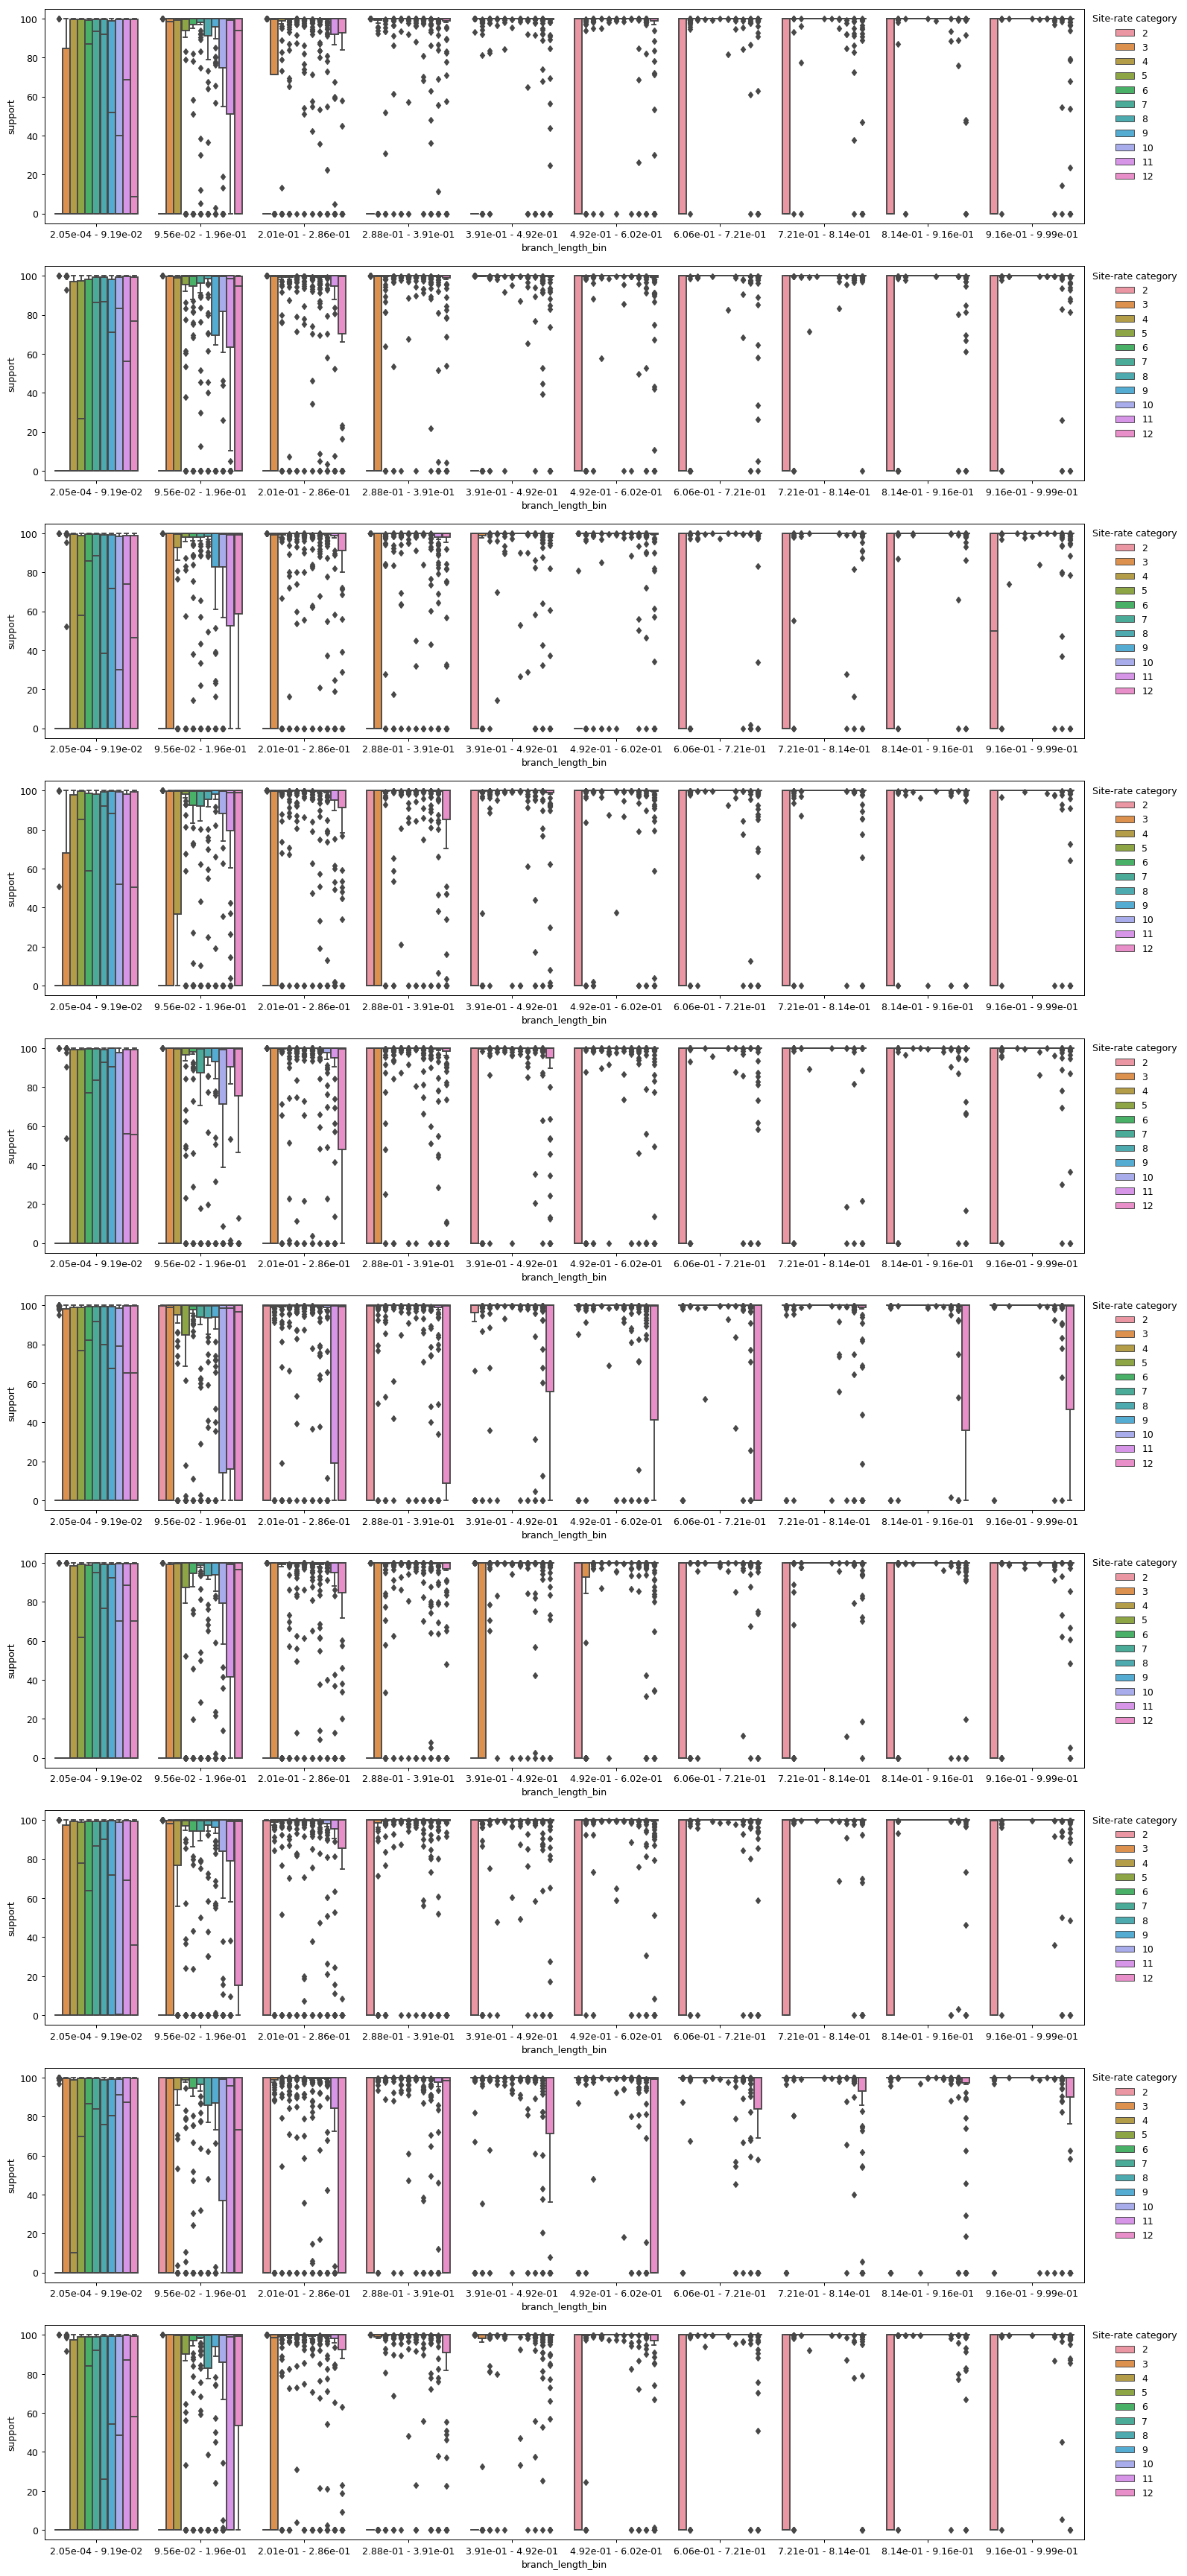

In [42]:
fig, axs = plt.subplots(dpi=90, nrows=10)
for replicate, ax in enumerate(axs, 1):
    tmp_df = category_support_df[category_support_df.replicate == replicate].copy()
    
    branch_lengths = tmp_df.loc[
        tmp_df.category == 2,
        'branch_length'.split()].values.squeeze()

    branch_length_bins = [np.percentile(branch_lengths, decile) for decile in range(10, 91, 10)]
    binning            = np.digitize(tmp_df['branch_length'].values.squeeze(), branch_length_bins)
    bin_names          = {}

    for bin in set(binning):
        min_binned_branch_len = tmp_df.loc[binning==bin, 'branch_length'].values.squeeze().min()
        max_binned_branch_len = tmp_df.loc[binning==bin, 'branch_length'].values.squeeze().max()
        bin_names[bin]        = '%.2e - %.2e' % (min_binned_branch_len, max_binned_branch_len)

    tmp_df['branch_length_bin'] = [bin_names[bin] for bin in binning]
    
    sns.boxplot(x='branch_length_bin', y='support', hue='category',
                order=bin_names.values(), data=tmp_df, ax=ax)
    fig.set_size_inches(25,6)
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.015), title='Site-rate category',frameon=False)
fig.tight_layout()
fig.set_size_inches(20,50)

In [43]:
%cd /work/site_rate/sequence_simulation/abg
category_support_df = pd.DataFrame(columns='replicate category topology_id support branch_length'.split())
for replicate in range(1, 11):
    print(replicate)
    for category in range(2, 13):
        print('\t', category)

        tmp_tree = ete3.Tree('categories/%i.%i.treefile' % (replicate, category))

        tmp_tree.set_outgroup(base_tree.children[0].get_leaf_names()[0])
        outgroup = tmp_tree.get_common_ancestor(base_tree.children[1].get_leaf_names())
        tmp_tree.set_outgroup(outgroup)

        tmp_supports       = []
        tmp_topology_ids   = []
        tmp_branch_lengths = []
        for node in tmp_tree.traverse():
            if not node.is_leaf() and not node.is_root():
                tmp_supports.append(node.support)
                tmp_topology_ids.append(node.get_topology_id())
                tmp_branch_lengths.append(node.dist)

        tmp_df = pd.DataFrame(
               list(zip([replicate]*len(tmp_supports),
                        [category]*len(tmp_supports),
                        tmp_topology_ids,
                        tmp_supports,
                        tmp_branch_lengths)),
                    columns='replicate category topology_id support branch_length'.split())
        category_support_df = category_support_df.append(tmp_df)

    for node in trees['abg'].traverse():
        if not node.is_leaf() and not node.is_root():
            tmp_topology_id = node.get_topology_id()
            category_support_df.loc[category_support_df.topology_id == tmp_topology_id, 'branch_length'] = node.dist

    category_support_df.to_csv('category_supports.tab', sep='\t')

/work/site_rate/sequence_simulation/abg
1
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
2
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
3
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
4
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
5
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
6
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
7
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
8
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
9
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12
10
	 2
	 3
	 4
	 5
	 6
	 7
	 8
	 9
	 10
	 11
	 12


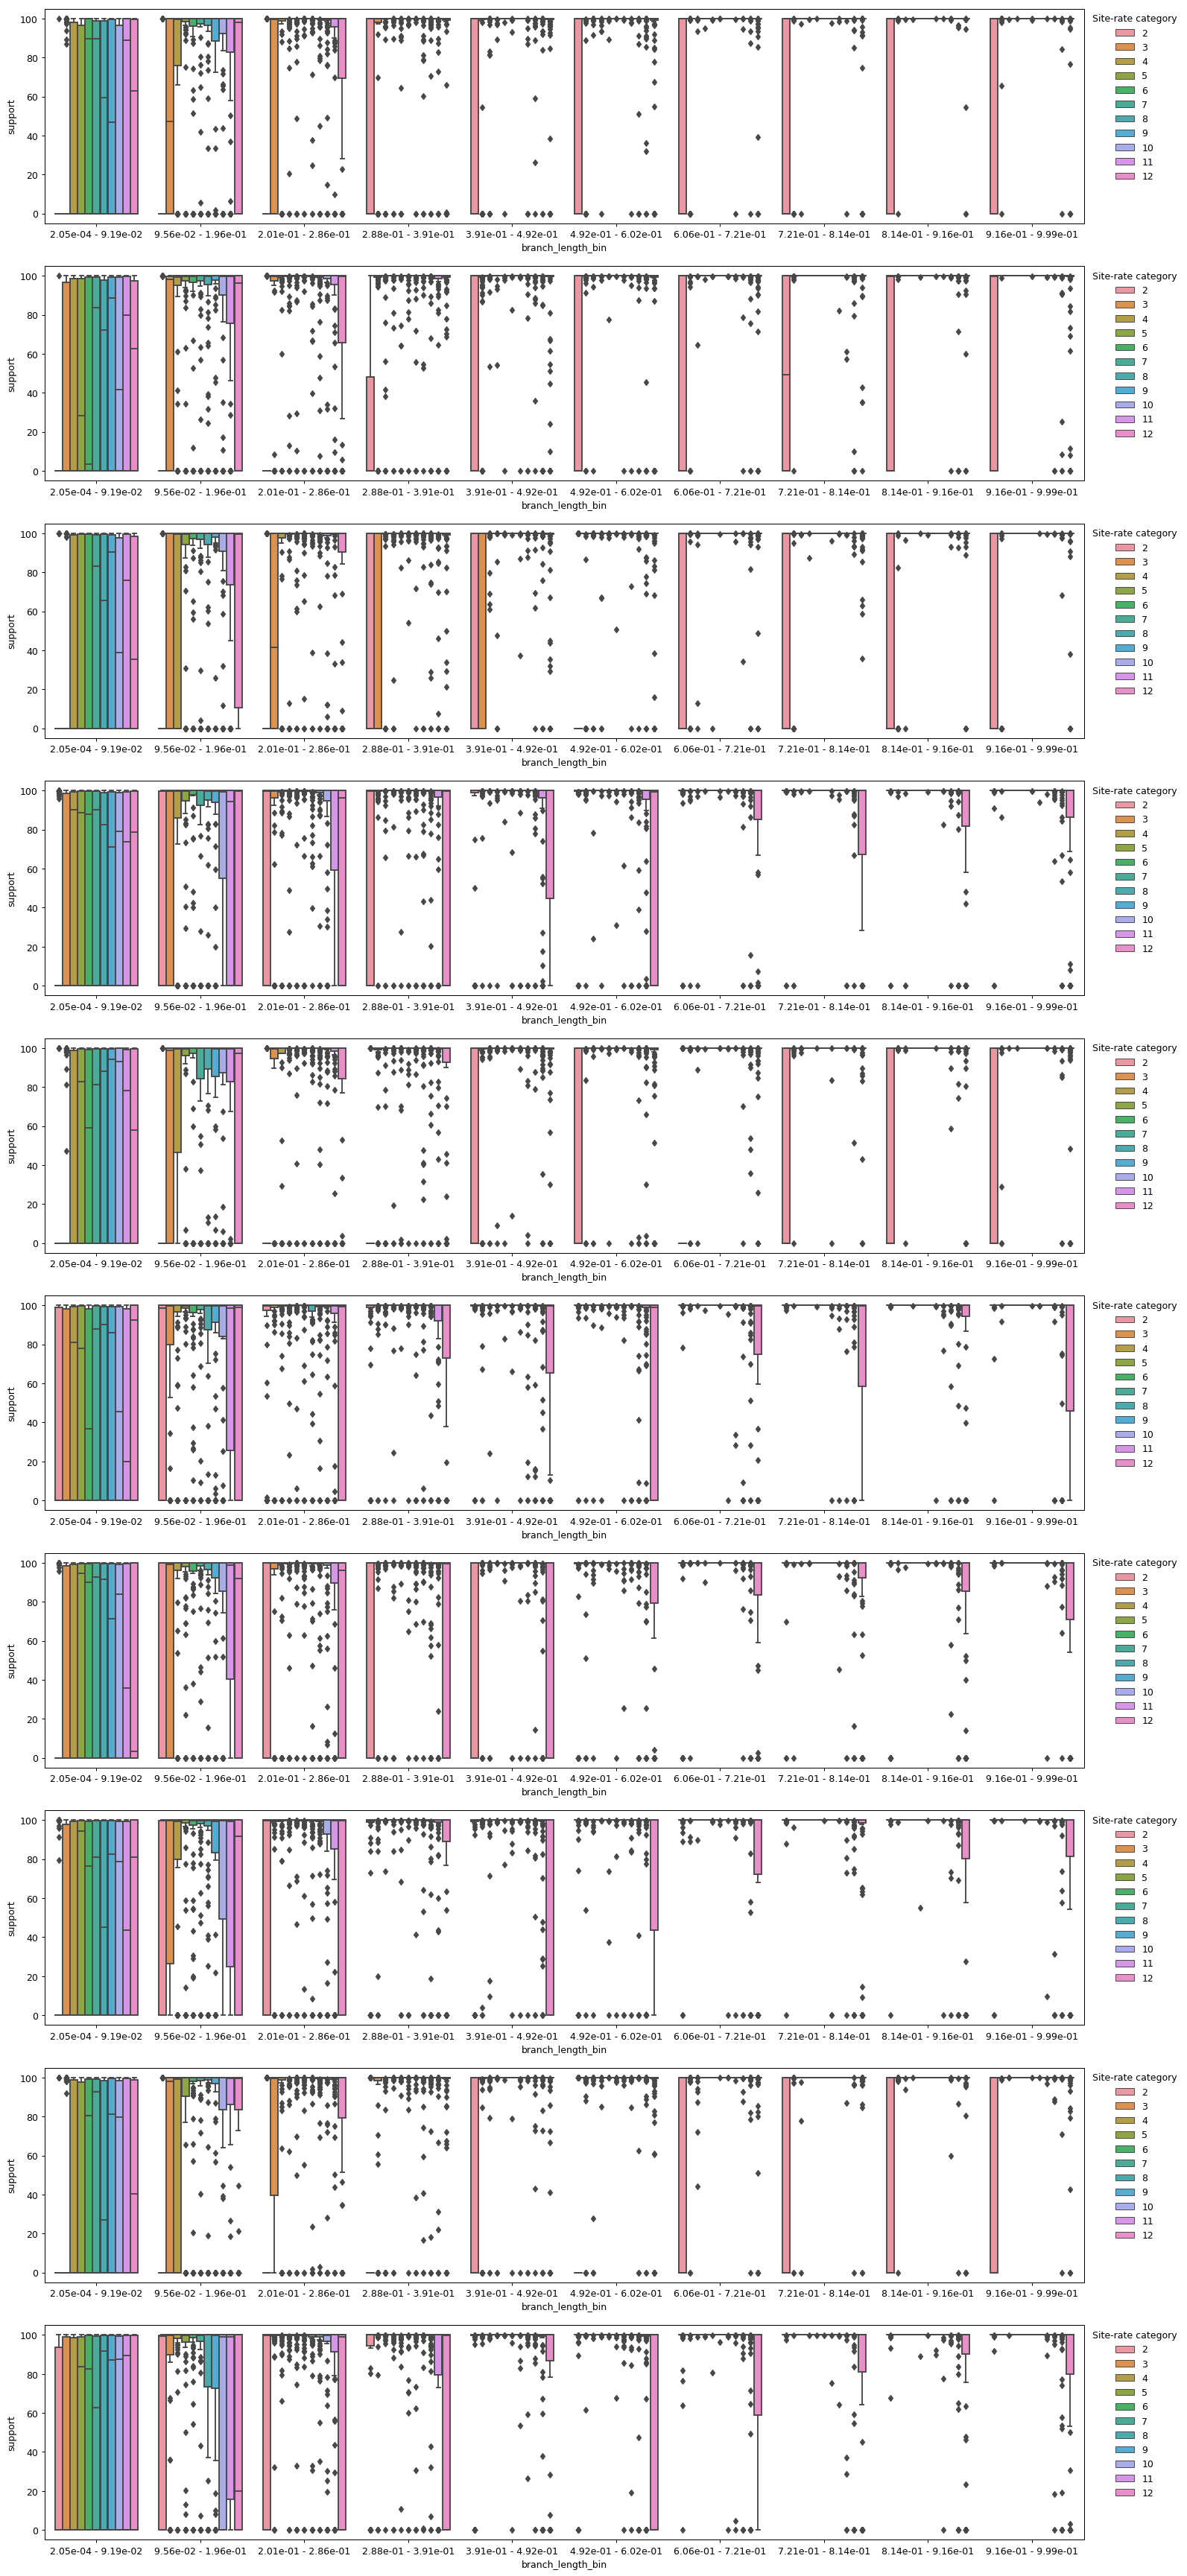

In [44]:
fig, axs = plt.subplots(dpi=90, nrows=10)
for replicate, ax in enumerate(axs, 1):
    tmp_df = category_support_df[category_support_df.replicate == replicate].copy()
    
    branch_lengths = tmp_df.loc[
        tmp_df.category == 2,
        'branch_length'.split()].values.squeeze()

    branch_length_bins = [np.percentile(branch_lengths, decile) for decile in range(10, 91, 10)]
    binning            = np.digitize(tmp_df['branch_length'].values.squeeze(), branch_length_bins)
    bin_names          = {}

    for bin in set(binning):
        min_binned_branch_len = tmp_df.loc[binning==bin, 'branch_length'].values.squeeze().min()
        max_binned_branch_len = tmp_df.loc[binning==bin, 'branch_length'].values.squeeze().max()
        bin_names[bin]        = '%.2e - %.2e' % (min_binned_branch_len, max_binned_branch_len)

    tmp_df['branch_length_bin'] = [bin_names[bin] for bin in binning]
    
    sns.boxplot(x='branch_length_bin', y='support', hue='category',
                order=bin_names.values(), data=tmp_df, ax=ax)
    fig.set_size_inches(25,6)
    ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.015), title='Site-rate category',frameon=False)
fig.tight_layout()
fig.set_size_inches(20,50)